<a href="https://colab.research.google.com/github/907Resident/pitch-sequence/blob/main/pitch_sequence_SO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pitch Sequences that Lead to Strike Outs

##Introduction

###Connect to Google Drive
Link to Google Drive so that zip files procured from Kaggle API sits in Google Drive instead of local machine to save space and for flexibility.  More details on how to set this up can be found on this Medium [post](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a) by Mrinali Gupta. 

In [1]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###Access data from Kaggle API
Kaggle has organized an API so that data, competition submissions, and other related materials can be accessed from a command interface. In order to acquire the data for this project, the Kaggle API was utilized. Read more [here](https://github.com/Kaggle/kaggle-api) about the API on GitHub. 

Create an environmental variable for the kaggle config file for Kaggle API get credentials. Follow the post mentioned above for specific instructions on how to access the necessary .json file.

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks/pitch-sequence"

Point current directory towards the appropriate directory in Google Drive

In [3]:
%cd /content/gdrive/My Drive/Colab Notebooks/pitch-sequence

/content/gdrive/My Drive/Colab Notebooks/pitch-sequence


Using the Kaggle API, access the data necessary for the project

In [4]:
# Install Kaggle API
!pip install -q --upgrade kaggle

In [5]:
# Examine the files available for the dataset
!kaggle datasets files pschale/mlb-pitch-data-20152018

name               size  creationDate         
----------------  -----  -------------------  
2019_pitches.csv  156MB  2020-05-17 22:24:27  
pitches.csv       795MB  2020-05-17 22:24:27  
ejections.csv      98KB  2020-05-17 22:24:27  
2019_games.csv    150KB  2020-05-17 22:24:27  
player_names.csv   45KB  2020-05-17 22:24:27  
games.csv           2MB  2020-05-17 22:24:27  
atbats.csv         42MB  2020-05-17 22:24:27  
2019_atbats.csv    12MB  2020-05-17 22:24:27  


In [6]:
# Download the pitches and at bats data set from 2019
!kaggle datasets download pschale/mlb-pitch-data-20152018 -f 2019_pitches.csv
!kaggle datasets download pschale/mlb-pitch-data-20152018 -f 2019_atbats.csv
!kaggle datasets download pschale/mlb-pitch-data-20152018 -f player_names.csv

2019_pitches.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
2019_atbats.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
player_names.csv: Skipping, found more recently modified local copy (use --force to force download)


## Import Data into Python
In this section, import the data into dataframes, assess missing data, and clean data for exploratory analysis to take place in the next session.

In [7]:
# Import data science packages
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

In [8]:
# Import data from competition .csv
df_pitches_19 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/2019_pitches.csv.zip")
# Take a look at the dimensions of the freshly imported dataframe.
df_pitches_19.shape

(728790, 40)

In [9]:
# Import data from competition .csv
df_atbats_19 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/2019_atbats.csv.zip")
# Take a look at the dimensions of the freshly imported dataframe.
df_atbats_19.shape

(185245, 11)

In [10]:
# Import data from competition .csv
df_names = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/player_names.csv")
# Take a look at the dimensions of the freshly imported dataframe.
df_names.shape

(2218, 3)

Join the pitch and at bat data  to get the pitcher ID into the former dataframe. This will allows us to know who is throwing the pitches. Drop all columns from at bat dataframe except pitcher ID, pitcher throws (p_throws), and event.

In [12]:
# Join the pitches and at bat dataframes
df_merged = df_pitches_19.merge(df_atbats_19, how="left", on="ab_id")

# Drop unncessary at bat columns
df_merged.drop(["o", "stand", "batter_id", "g_id", "top"], 
               inplace = True, axis = 1)

# Preview dataframe
df_merged.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,sz_bot,sz_top,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone,code,type,pitch_type,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,inning,p_score,pitcher_id,p_throws,event
0,0.00,2.15,88.8,80.7,placeholder,placeholder,22.8,4.8,24.0,-8.47,28.90,-15.51,1.70,3.36,placeholder,5.28,-128.95,-6.89,116.97,-1.42,180.81,50.0,6.07,-5.07,9.98,NaN,placeholder,X,X,FF,5,0.0,2.019000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,571666,R,Flyout
1,0.34,2.31,89.9,81.8,placeholder,placeholder,22.8,3.6,24.0,-7.10,28.85,-12.99,1.80,3.55,placeholder,4.89,-130.54,-7.48,103.93,-1.02,176.34,50.0,6.20,-4.14,11.18,NaN,placeholder,C,C,FF,8,0.0,2.019000e+09,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,571666,R,Flyout
2,-0.05,2.03,85.7,79.6,placeholder,placeholder,9.6,6.0,24.0,3.65,22.07,-22.64,1.59,3.55,placeholder,2.33,-124.60,-5.98,118.86,-1.29,183.96,50.0,6.30,2.30,5.99,NaN,placeholder,S,S,SL,9,0.0,2.019000e+09,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,571666,R,Flyout
3,0.49,0.92,85.4,78.5,placeholder,placeholder,24.0,7.2,24.0,-13.77,24.44,-25.74,1.74,3.55,placeholder,7.83,-123.74,-6.78,98.15,-1.56,214.03,50.0,5.85,-8.87,4.14,NaN,placeholder,B,B,CH,10,0.0,2.019000e+09,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,571666,R,Flyout
4,-0.13,1.11,84.6,77.6,placeholder,placeholder,26.4,8.4,24.0,-15.99,24.56,-28.36,1.83,3.59,placeholder,6.79,-122.67,-5.73,121.81,-1.57,208.77,50.0,5.89,-10.51,2.51,NaN,placeholder,B,B,CH,11,0.0,2.019000e+09,1.0,1.0,1.0,4.0,0.0,0.0,0.0,1.0,0.0,571666,R,Flyout


In [13]:
# Drop pitching location data
df_merged.drop(["px", "pz", "break_angle", "break_length", "break_y", "ax", 
                "ay", "az","sz_bot", "sz_top" , "vx0", "vy0", "vz0", "x", 
                "x0", "y", "y0", "z0", "pfx_x", "pfx_z", "zone", "type",
                "event_num", "on_1b", "on_2b", "on_3b"], 
        inplace = True, axis = 1)

# Preview dataframe
df_merged.head()

,start_speed,end_speed,spin_rate,spin_dir,type_confidence,nasty,code,pitch_type,b_score,ab_id,b_count,s_count,outs,pitch_num,inning,p_score,pitcher_id,p_throws,event
0,88.8,80.7,placeholder,placeholder,placeholder,NaN,X,FF,0.0,2.019000e+09,0.0,0.0,0.0,1.0,1.0,0.0,571666,R,Flyout
1,89.9,81.8,placeholder,placeholder,placeholder,NaN,C,FF,0.0,2.019000e+09,0.0,0.0,1.0,1.0,1.0,0.0,571666,R,Flyout
2,85.7,79.6,placeholder,placeholder,placeholder,NaN,S,SL,0.0,2.019000e+09,0.0,0.0,1.0,2.0,1.0,0.0,571666,R,Flyout
3,85.4,78.5,placeholder,placeholder,placeholder,NaN,B,CH,0.0,2.019000e+09,0.0,1.0,1.0,3.0,1.0,0.0,571666,R,Flyout
4,84.6,77.6,placeholder,placeholder,placeholder,NaN,B,CH,0.0,2.019000e+09,1.0,1.0,1.0,4.0,1.0,0.0,571666,R,Flyout


In [14]:
# Get the new shape of the main dataframe
df_merged.shape

(728790, 19)

Merge the player names to the the dataframe

In [15]:
# Merge main df to the player names with pitcher ID
df = df_merged.merge(df_names, how="left", left_on="pitcher_id", right_on="id")

# Drop "id" column from player names dataframe
df.drop(["id"],
        inplace = True, axis = 1)

# Preview main dataframe
df.head()

,start_speed,end_speed,spin_rate,spin_dir,type_confidence,nasty,code,pitch_type,b_score,ab_id,b_count,s_count,outs,pitch_num,inning,p_score,pitcher_id,p_throws,event,first_name,last_name
0,88.8,80.7,placeholder,placeholder,placeholder,NaN,X,FF,0.0,2.019000e+09,0.0,0.0,0.0,1.0,1.0,0.0,571666,R,Flyout,Mike,Fiers
1,89.9,81.8,placeholder,placeholder,placeholder,NaN,C,FF,0.0,2.019000e+09,0.0,0.0,1.0,1.0,1.0,0.0,571666,R,Flyout,Mike,Fiers
2,85.7,79.6,placeholder,placeholder,placeholder,NaN,S,SL,0.0,2.019000e+09,0.0,0.0,1.0,2.0,1.0,0.0,571666,R,Flyout,Mike,Fiers
3,85.4,78.5,placeholder,placeholder,placeholder,NaN,B,CH,0.0,2.019000e+09,0.0,1.0,1.0,3.0,1.0,0.0,571666,R,Flyout,Mike,Fiers
4,84.6,77.6,placeholder,placeholder,placeholder,NaN,B,CH,0.0,2.019000e+09,1.0,1.0,1.0,4.0,1.0,0.0,571666,R,Flyout,Mike,Fiers


Reorder the dataframe so that the pitcher IDs and their names at at far left of the dataframe. Currently, there is not a simply way to move the columns;
therefore: 

*   move the necessary columns to the left with the `insert()` function with misspelled titles
*   delete the original column
*   rename the purposefully misspelled columns to the correct spelling


In [26]:
# Move pitcher ID to the front
df.insert(0, "pitche_id", df.pitcher_id)

# Move First Name next to pitcher ID
df.insert(1, "firs_name", df.first_name)

# Move Last Name next to First Name
df.insert(2, "las_name", df.last_name)

# Drop Duplicates
df.drop(labels=["pitcher_id", "first_name", "last_name"], 
                   axis=1, inplace=True)

# Rename misspled column names
df.rename(columns = {'pitche_id':'pitcher_id', 
                     'firs_name':'first_name',
                     'las_name':'last_name'}, 
          inplace = True)

# Fill missing data with "NA"
#df.fillna(value="NA", inplace=True)

# Preview dataframe
df.head()

,pitcher_id,first_name,last_name,start_speed,end_speed,spin_rate,spin_dir,type_confidence,nasty,code,pitch_type,b_score,ab_id,b_count,s_count,outs,pitch_num,inning,p_score,p_throws,event
0,571666,Mike,Fiers,88.8,80.7,placeholder,placeholder,placeholder,NaN,X,FF,0.0,2019000001,0,0,0,1.0,1,0,R,Flyout
1,571666,Mike,Fiers,89.9,81.8,placeholder,placeholder,placeholder,NaN,C,FF,0.0,2019000002,0,0,1,1.0,1,0,R,Flyout
2,571666,Mike,Fiers,85.7,79.6,placeholder,placeholder,placeholder,NaN,S,SL,0.0,2019000002,0,0,1,2.0,1,0,R,Flyout
3,571666,Mike,Fiers,85.4,78.5,placeholder,placeholder,placeholder,NaN,B,CH,0.0,2019000002,0,1,1,3.0,1,0,R,Flyout
4,571666,Mike,Fiers,84.6,77.6,placeholder,placeholder,placeholder,NaN,B,CH,0.0,2019000002,1,1,1,4.0,1,0,R,Flyout


In [29]:
# Add correct data types
## Change certain categories to integers to remove decimal point
df = df.astype({"start_speed":"float64", "end_speed":"float64", 
                "code":"category", "pitch_type":"category", 
                "outs":"int", "event":"category", "b_count":"int",
                "s_count":"int", "p_score":"int", "pitch_num":"int",
                "inning":"int", "ab_id":"str", "first_name":"str",
                "last_name":"str"})
## Set appropriate columns to categories
df = df.astype({"outs":"category", "b_count":"category", "s_count":"category"})

# Set order for appropriate categories
## Outs
df.outs.cat.reorder_categories([0, 1, 2], ordered = True, inplace = True)
## Balls in count
df.b_count.cat.reorder_categories([0, 1, 2, 3, 4], ordered = True, 
                                  inplace = True)
## Strikes in count
df.s_count.cat.reorder_categories([0, 1, 2], ordered = True,
                                  inplace = True)

# View data types of dataframe
df.dtypes

pitcher_id            int64
first_name           object
last_name            object
start_speed         float64
end_speed           float64
spin_rate            object
spin_dir             object
type_confidence      object
nasty               float64
code               category
pitch_type         category
b_score             float64
ab_id                object
b_count            category
s_count            category
outs               category
pitch_num             int64
inning                int64
p_score               int64
p_throws             object
event              category
dtype: object

## Exploratory Data Analysis
With a clean dataset of pitches during the 2019 season, it is time to dive in and analyze. 

### Visualize important metrics
Start by getting a feel of the important metrics in the dataset. Some of these important metrics are:


*   `start_speed`
*   `end_speed`
*   `event`
*   `pitch_type`
*   `b_count`
*   `s_count`
*   `last_name`

Best place to start is understanding which is the most common pitch type



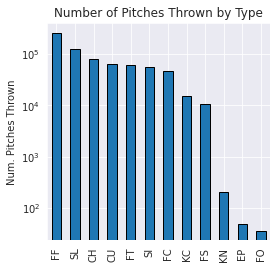

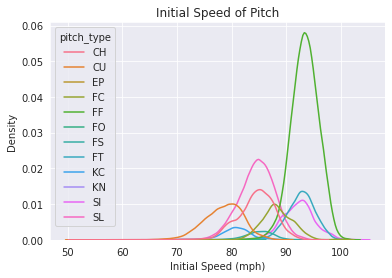

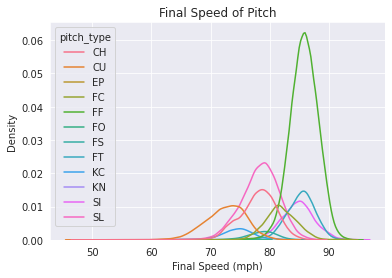

In [18]:
# Set graph style
sns.set_style("darkgrid")

# Graph pitch types
## Absolute Number of Pitches
plt.figure(figsize=(4,4))
df.pitch_type.value_counts().plot(kind="bar", edgecolor="k")
plt.yscale("log")
plt.title("Number of Pitches Thrown by Type")
plt.ylabel("Num. Pitches Thrown")
plt.show()

## Density plot of pitch speed by pitch type
### Start Velocity
plt.figure()
sns.kdeplot(x=df["start_speed"], hue=df["pitch_type"])
plt.title("Initial Speed of Pitch")
plt.xlabel("Initial Speed (mph)")
plt.show()
### End Velocity
plt.figure()
sns.kdeplot(x=df["end_speed"], hue=df["pitch_type"])
plt.title("Final Speed of Pitch")
plt.xlabel("Final Speed (mph)")
plt.show()

Examine what pitches are thrown in different situations. A mosaic plot is great for plotting two catgeorical variables.  Get the `mosaic()` function from the `statsmodels.graphics` module

For instance, when there is 0, 1, or 2 outs, what pitch is thrown?

In [19]:
# Tried to edit the categories of pitch type the most relevant ones. For some 
# reason, I could not eliminate the three bottom pitch types from showing up as 
# zero. As a result, even though the bottom three are filtered out, the mosaic 
# plot does not work [Make this an issue]

'''
# Filter for pitches that were thrown more than 1000 times (see "Number of Pitches Thrown by Type")
## Get the pitches that were thrown more than the threshold
relev_pitches = df["pitch_type"].value_counts()>1000
rp = relev_pitches[relev_pitches == True]
rp = list(rp.index)
## Show the relevant pitches
print(rp)

## Select only the relevant pitches from the main dataframe
df_rp = df[df['pitch_type'].isin(rp)]
df_rp.pitch_type.value_counts()

# Create a crosstab dataframe for pitch type and outs
df_xtab = pd.crosstab(df_rp.pitch_type, df_rp.outs)
df_xtab.head(10)
'''

'\n# Filter for pitches that were thrown more than 1000 times (see "Number of Pitches Thrown by Type")\n## Get the pitches that were thrown more than the threshold\nrelev_pitches = df["pitch_type"].value_counts()>1000\nrp = relev_pitches[relev_pitches == True]\nrp = list(rp.index)\n## Show the relevant pitches\nprint(rp)\n\n## Select only the relevant pitches from the main dataframe\ndf_rp = df[df[\'pitch_type\'].isin(rp)]\ndf_rp.pitch_type.value_counts()\n\n# Create a crosstab dataframe for pitch type and outs\ndf_xtab = pd.crosstab(df_rp.pitch_type, df_rp.outs)\ndf_xtab.head(10)\n'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


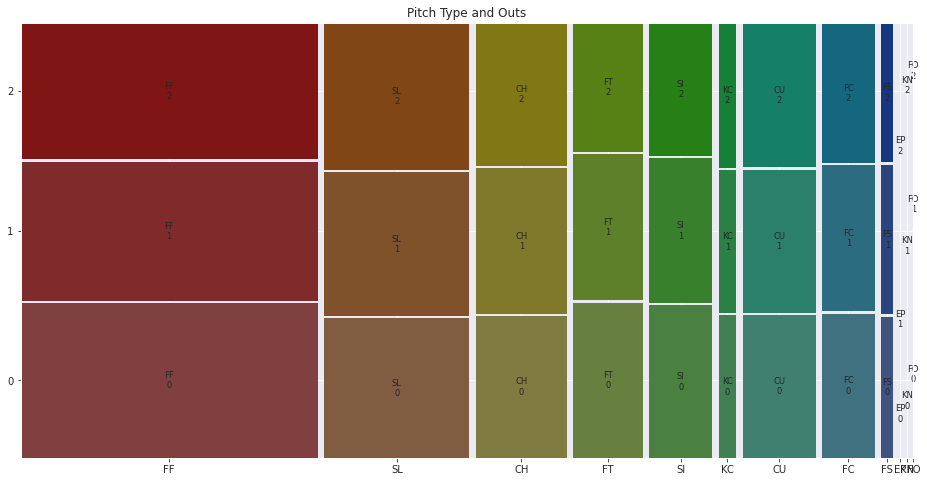

In [20]:
# Mosaic plot for pitch type and outs in the count
## Import mosaic function
from statsmodels.graphics.mosaicplot import mosaic

# Create marginal table
plt.rcParams["figure.figsize"]=(16, 8)
mosaic(df, ["pitch_type", "outs"],
       gap = 0.008,
       title="Pitch Type and Outs")
plt.ylabel("Outs")
plt.show()

The mosaic plot shows that the four-seam fastball (FF) is dominant pitch but also shows an approximate equal distribution of FF pitches in all three out scenarios. 

Furthermore, the mosaic plot shows that the slider (SL) and knukle curve (KC) are thrown more often with two outs than with one or zero. Also, the chart also demonstrates that the SL is thrown far more often than the KC based on the width of the bars. Therefore, we now have some information about how the game may affect pitch type,

Now, let us go back to the KDE plots and examine pitch type when there are 0, 1, or 2 strikes in the count and how it relates to the type of pitch thrown. 

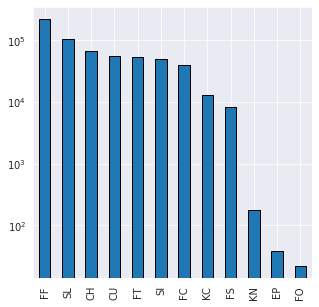

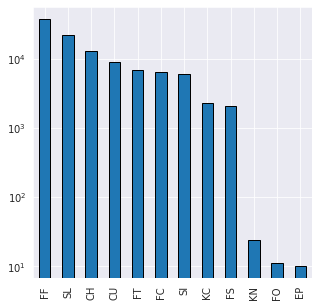

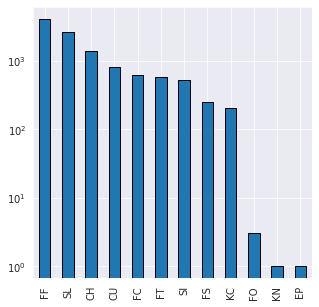

In [21]:
# Plot pitch type by strikes in count
## Create a dataframe with pitch type and zero strikes
### Get the relevant columns
df_bls_strx = df[["pitcher_id","last_name","pitch_type","s_count", "b_count"]]
### Zero Strikes
plt.figure(figsize=(5,5))
df_bls_strx[df_bls_strx["s_count"] == 0].pitch_type.value_counts().plot(
    kind="bar", edgecolor="k")
plt.yscale("log")
plt.show()

### One Strike
plt.figure(figsize=(5,5))
df_bls_strx[df_bls_strx["s_count"] == 1].pitch_type.value_counts().plot(
    kind="bar", edgecolor="k")
plt.yscale("log")
plt.show()

### Two Strikes
plt.figure(figsize=(5,5))
df_bls_strx[df_bls_strx["s_count"] == 2].pitch_type.value_counts().plot(
    kind="bar", edgecolor="k")
plt.yscale("log")
plt.show()


In [176]:
df_bls_strx.shape

(728790, 5)

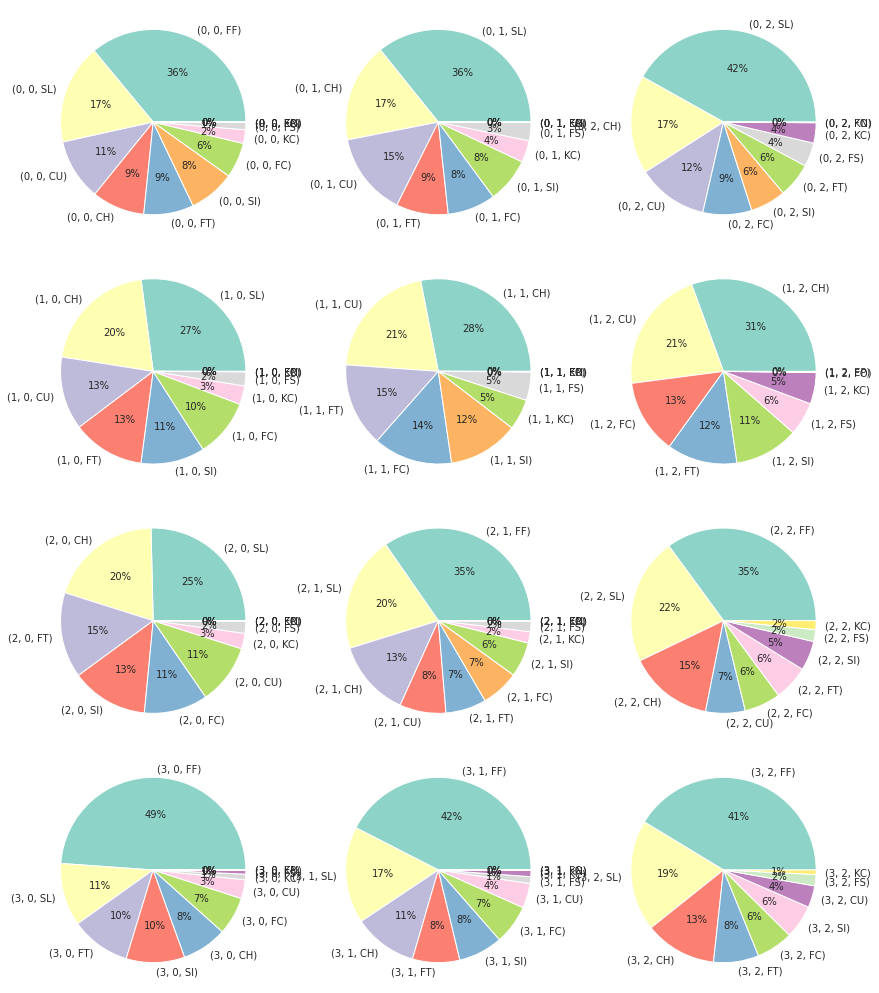

In [184]:
ptype_labs = ["FF", "SL", "CH", "CU", "FC", "FT", "SI", "FS", "KC", "FO", "KM",
              "EP"]
df_count_ptype = df_bls_strx.groupby(["b_count", "s_count"]).pitch_type.value_counts()

cmap = "Set3"
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,8))
# 0,0 count
df_count_ptype[:12].plot(kind="pie", autopct='%1.0f%%', cmap=cmap,
                         ax=ax[0,0])
ax[0,0].set_ylabel('')
# 0,1 count
df_count_ptype[13:24].plot(kind="pie", autopct='%1.0f%%', cmap=cmap,
                           ax=ax[0,1])
ax[0,1].set_ylabel('')
# 0,2 count
df_count_ptype[25:35].plot(kind="pie", autopct='%1.0f%%', cmap=cmap,
                           ax=ax[0,2])
ax[0,2].set_ylabel('')
# 1,0 count
df_count_ptype[36:47].plot(kind="pie", autopct='%1.0f%%', cmap=cmap,
                           ax=ax[1,0])
ax[1,0].set_ylabel('')
# 1,1 count
df_count_ptype[49:59].plot(kind="pie", autopct='%1.0f%%', cmap=cmap,
                           ax=ax[1,1])
ax[1,1].set_ylabel('')
# 1,2 count
df_count_ptype[61:70].plot(kind="pie", autopct='%1.0f%%', cmap=cmap,
                           ax=ax[1,2])
ax[1,2].set_ylabel('')
# 2,0 count
df_count_ptype[71:82].plot(kind="pie", autopct='%1.0f%%', cmap=cmap,
                           ax=ax[2,0])
ax[2,0].set_ylabel('')
# 2,1 count
df_count_ptype[82:94].plot(kind="pie", autopct='%1.0f%%', cmap=cmap,
                           ax=ax[2,1])
ax[2,1].set_ylabel('')
# 2,2 count
df_count_ptype[94:103].plot(kind="pie", autopct='%1.0f%%', cmap=cmap,
                            ax=ax[2,2])
ax[2,2].set_ylabel('')
# 3,0 count
df_count_ptype[103:114].plot(kind="pie", autopct='%1.0f%%', cmap=cmap,
                             ax=ax[3,0])
ax[3,0].set_ylabel('')
# 3,1 count
df_count_ptype[114:125].plot(kind="pie", autopct='%1.0f%%', cmap=cmap,
                             ax=ax[3,1])
ax[3,1].set_ylabel('')
# 3,2 count
df_count_ptype[125:134].plot(kind="pie", autopct='%1.0f%%', cmap=cmap,
                             ax=ax[3,2])
ax[3,2].set_ylabel('')

f = plt.gcf()
f.set_size_inches(12,14)
plt.tight_layout()
plt.show()

In [23]:
list(df_bls_strx.pitch_type.cat.categories)

['CH', 'CU', 'EP', 'FC', 'FF', 'FO', 'FS', 'FT', 'KC', 'KN', 'SI', 'SL']

## Baseline Analysis
To start off, create a simple machine learning model that quantifies the probability of a pitch occuring in a strike out sequence. 

The first portion of the analysis explores the likely outcomes in a 2-strike count. 

### 2-Strike Count Baseline

In [260]:
df_k_2S = df[(df["s_count"] == 2)]
df_k_2S.drop_duplicates(subset=["ab_id"], keep="last", inplace=True)
df_k_2S.reset_index(inplace=True, drop=True)
df_k_2S.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,pitcher_id,first_name,last_name,start_speed,end_speed,spin_rate,spin_dir,type_confidence,nasty,code,pitch_type,b_score,ab_id,b_count,s_count,outs,pitch_num,inning,p_score,p_throws,event
0,502239,Trevor,Cahill,91.2,83.3,placeholder,placeholder,placeholder,NaN,X,SI,2.0,2019000023,0,2,1,4,3,0,R,Fielders Choice Out
1,527054,Julio,Teheran,93.7,86.1,placeholder,placeholder,placeholder,NaN,B,FF,1.0,2019000169,3,2,2,6,4,1,R,Walk
2,605400,Aaron,Nola,91.3,83.6,placeholder,placeholder,placeholder,NaN,C,FT,1.0,2019000176,2,2,2,5,5,3,R,Strikeout
3,641438,Shane,Carle,81.2,75.4,placeholder,placeholder,placeholder,NaN,W,CU,3.0,2019000186,0,2,1,4,6,1,R,Strikeout
4,608331,Max,Fried,95.2,87.2,placeholder,placeholder,placeholder,NaN,X,FF,10.0,2019000208,3,2,1,6,8,4,L,Groundout


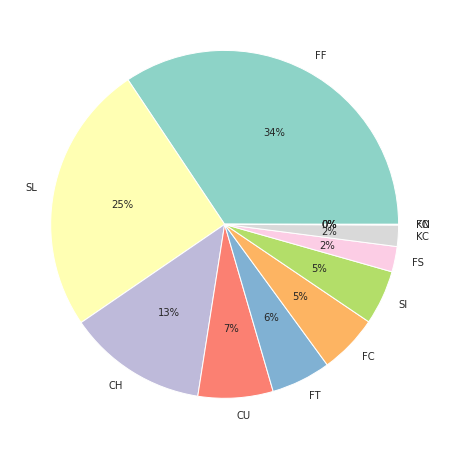

In [332]:
df_k_2S_cnt = df_k_2S.pitch_type.value_counts()
df_k_2S_cnt.plot(kind="pie", autopct='%1.0f%%', cmap=cmap)
plt.ylabel('')
plt.show()

This pie chart shows the probability of pitch type selected when the result is a strikeout and there are two strikes in the count. To be clear, this is the pitch that was selected that resulted in the strikeout. 

In [262]:
(df_k_2S["event"]== "Strikeout").mean()

0.5083984375

About half of the time the data shows that pitcher is able to strikeout the batter when there are two strikes in the count.

In [300]:
df_k_2S["is_SO"] = (df_k_2S["event"]== "Strikeout")
df_k_2S.groupby(["pitch_type"])["is_SO"].mean().sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


pitch_type
KC    0.594059
SL    0.551482
CU    0.538028
FF    0.515134
CH    0.512859
FS    0.508333
FO    0.500000
SI    0.434109
FC    0.428571
FT    0.347518
KN    0.000000
EP         NaN
Name: is_SO, dtype: float64

This simple analysis demonstrates the probability depending on pitch type selection for 2-strike counts that end in a strikeout. Though all of the pitch types represented are not thrown in equal amounts (see EDA), the knucklecurve (KC) results in a strikeout almost 60% of the time its is thrown in a 2-strike count scenario. More common pitches, such as the slider (SL), curveball (CU), four-seam fastball (FF), change up (CH), and splitter (FS) result in strikeouts in the same count situation between 51 and 55% of the time. Surprisingly, sinkers (SI) only result in strikeouts 43% of the time suggesting that batters take (do not swing) at that pitch.

In [341]:
# Crosstab analysis
df_ptype_xtab_event = \
pd.crosstab(df_k_2S["pitch_type"], df_k_2S["event"],
            normalize="index").\
drop(columns=["Batter Interference", "Catcher Interference", 
              "Caught Stealing 2B", "Caught Stealing Home", 
              "Pickoff Caught Stealing Home", "Runner Out",
              "Sac Fly Double Play"])
## Ensure column names are unattached to "event"
df_ptype_xtab_event.columns = df_ptype_xtab_event.columns.to_list()

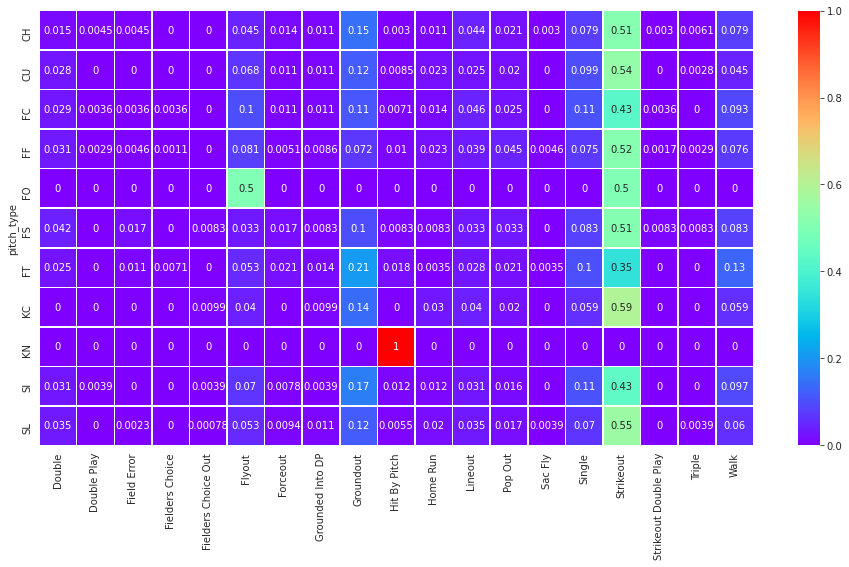

In [342]:
# Simple heatmap
sns.heatmap(df_ptype_xtab_event, cmap="rainbow", linewidths=0.5, linecolor="w",
            annot=True)

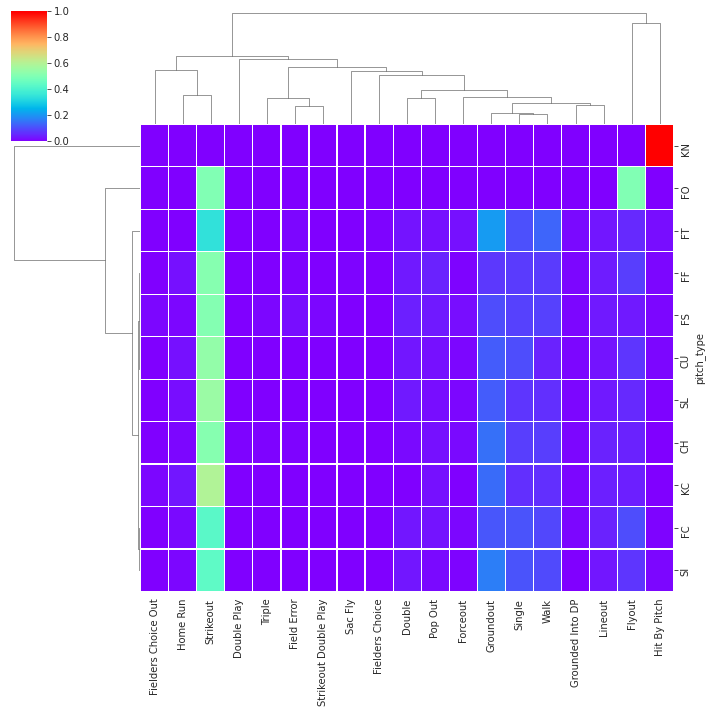

In [352]:
# Simple clustermap
clust = sns.clustermap(df_ptype_xtab_event, cmap="rainbow", metric="correlation",
               linewidth=0.25, annot=False)

This heatmap highlights the terminal scenarios that occur after the pitch is thrown in the two strike count. It is relatively clear, as mentioned earlier, that the result ends in a strike out about half the time for all pitches. The only exception is the knuckleball (KN), which appears to have only been thrown a few times (possibly only once) and it hit a batter. Again, the curveball (CU) and slider (SL) are the pitches that lead to a strikeout in this 2-strike count the most often.

The clustermap examines how the pitch type and event types are related to one another. The clustermap clearly sets apart the knuckleball (KN) from the rest of the pitches. Also the pitchout (FO) is also seperated from the rest of the pitches (relevant pitches) as well. It appears, from the event side of things, grounding out, getting a single or a walk are all loosely related to the most relevant pitch types. Grounding out is slighly seperate from getting a single or a walk.

As the heatmap indicated, there is not a huge difference between the relevant pitches in terms of strikeout probability if you allow for a 5% difference between piches. However, the clustermap reveals that there is a correlative relationship between sinkers (SI) and cutters (FC) as well as curveballs (CU) and splitters (FS). 

## Reinforcement Learning

State space: in the simple model, the state space only includes the number of strikes and balls (i.e. the pitch count)

In [291]:
states = np.matrix([
          [0,0],
          [0,1],
          [0,2],
          [1,0],
          [1,1],
          [1,2],
          [2,0],
          [2,1],
          [2,2],
          [3,0],
          [3,1],
          [3,2],
          ])

matrix([[0, 0],
        [0, 1],
        [0, 2],
        [1, 0],
        [1, 1],
        [1, 2],
        [2, 0],
        [2, 1],
        [2, 2],
        [3, 0],
        [3, 1],
        [3, 2]])

Action space: the pitch types that can be thrown. In all there are 11 pitches that are contained within the dataset

In [292]:
action = np.matrix(np.zeros(shape=(12,11)))

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])